In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
pip install module-wrapper


   ---------------------------------------- 0.0/63.5 kB ? eta -:--:--
   ------ --------------------------------- 10.2/63.5 kB ? eta -:--:--
   ---------------------------------------- 63.5/63.5 kB 674.3 kB/s eta 0:00:00


In [5]:
pip install keras==2.12.0

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 281.8 kB/s eta 0:00:07
   - -------------------------------------- 0.1/1.7 MB 393.8 kB/s eta 0:00:05
   -- ------------------------------------- 0.1/1.7 MB 554.9 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.7 MB 962.7 kB/s eta 0:00:02
   --------- ------------------------------ 0.4/1.7 MB 1.4 MB/s eta 0:00:01
   ------------ --------------------------- 0.6/1.7 MB 1.6 MB/s eta 0:00:01
   -------------------- ------------------- 0.9/1.7 MB 2.2 MB/s eta 0:00:01
   --------------------------- ------------ 1.2/1.7 MB 2.7 MB/s eta 0:00:01
   -------------------------------- ------- 1.4/1.7 MB 2.9 MB/s eta 0:00:01
   --------------------------------- ------ 1.5/1.7 MB 2.7 MB/s eta 0:00:01
   ----------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.1 requires keras>=3.0.0, but you have keras 2.12.0 which is incompatible.


In [21]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

datapath = join('data', 'wafer')

print(os.listdir(r"C:\Users\user\water_defect_detection/input"))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


In [23]:
df=pd.read_pickle(r"C:\Users\user\water_defect_detection/input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [24]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [25]:
df = df.drop(['waferIndex'], axis = 1)


In [26]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
254117,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4612.0,lot15724,[],[],"(81, 73)"
95593,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1522.0,lot6731,[],[],"(56, 35)"
93025,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",682.0,lot6596,[],[],"(31, 28)"
272185,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1139.0,lot16768,[],[],"(38, 38)"
513162,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot32054,[],[],"(25, 27)"


In [27]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [28]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [33]:
# Filter df based on failureNum
df_withlabel = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 8)]
# Reset the index of the filtered dataframe
df_withlabel = f_withlabel.reset_index()

# Similarly, for df_withpattern
df_withpattern = df[(df['failureNum'] >= 0) & (df['failureNum'] <= 7)]
df_withpattern = df_withpattern.reset_index()

# Continue with the rest of the code...



In [34]:
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

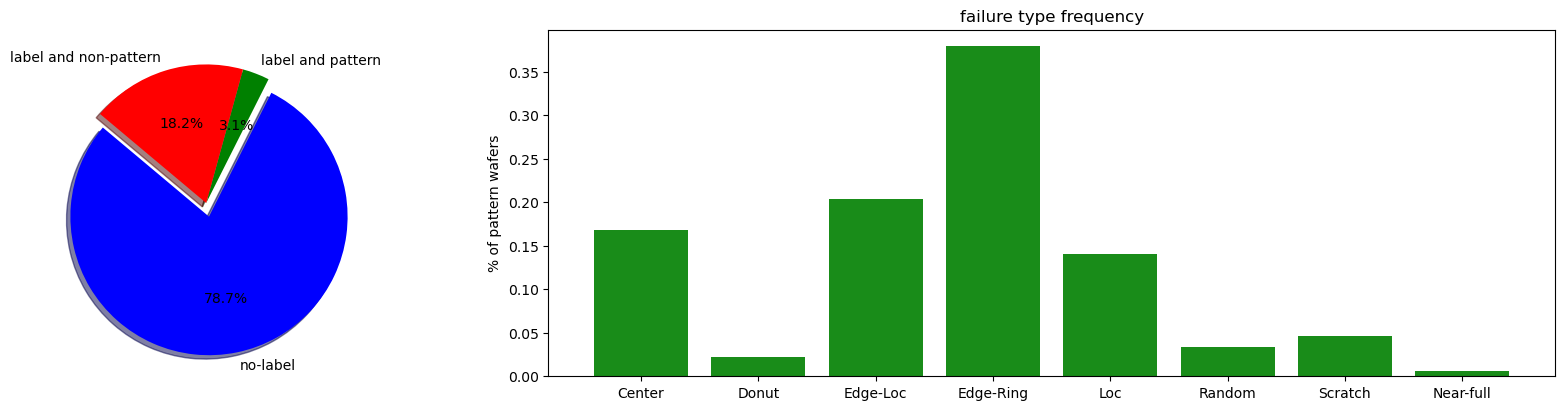

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['blue', 'green', 'red']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label and pattern','label and non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='green', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

In [36]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [37]:
x = sw[1:]
y = np.array(label).reshape((-1,1))
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


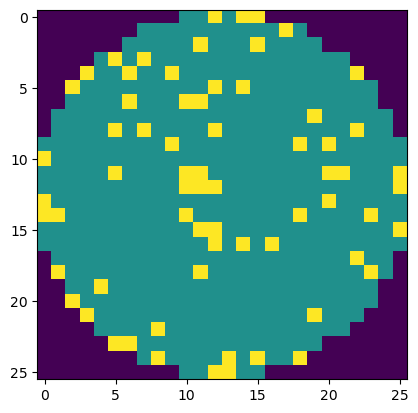

Faulty case : ['none'] 


In [38]:
plt.imshow(x[2040])
plt.show()

print('Faulty case : {} '.format(y[2040]))

In [39]:
x = x.reshape((-1, 26, 26, 1))


In [40]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [41]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))
    

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [42]:
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1
new_x.shape

(14366, 26, 26, 3)

In [43]:
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [44]:
epoch=30
batch_size=1024

In [45]:
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 15s - 1s/step - loss: 0.1618
Epoch 2/30
15/15 - 8s - 523ms/step - loss: 0.0954
Epoch 3/30
15/15 - 7s - 483ms/step - loss: 0.0838
Epoch 4/30
15/15 - 7s - 488ms/step - loss: 0.0725
Epoch 5/30
15/15 - 7s - 492ms/step - loss: 0.0629
Epoch 6/30
15/15 - 8s - 506ms/step - loss: 0.0563
Epoch 7/30
15/15 - 7s - 497ms/step - loss: 0.0509
Epoch 8/30
15/15 - 8s - 529ms/step - loss: 0.0459
Epoch 9/30
15/15 - 7s - 499ms/step - loss: 0.0410
Epoch 10/30
15/15 - 7s - 500ms/step - loss: 0.0355
Epoch 11/30
15/15 - 8s - 508ms/step - loss: 0.0308
Epoch 12/30
15/15 - 8s - 519ms/step - loss: 0.0275
Epoch 13/30
15/15 - 8s - 508ms/step - loss: 0.0246
Epoch 14/30
15/15 - 8s - 519ms/step - loss: 0.0223
Epoch 15/30
15/15 - 8s - 547ms/step - loss: 0.0205
Epoch 16/30
15/15 - 8s - 517ms/step - loss: 0.0190
Epoch 17/30
15/15 - 8s - 515ms/step - loss: 0.0175
Epoch 18/30
15/15 - 8s - 507ms/step - loss: 0.0164
Epoch 19/30
15/15 - 8s - 518ms/step - loss: 0.0153
Epoch 20/30
15/15 - 8s - 502ms/step - loss

In [46]:
encoder = models.Model(input_tensor, latent_vector)
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

encoded_x = encoder.predict(new_x)

noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


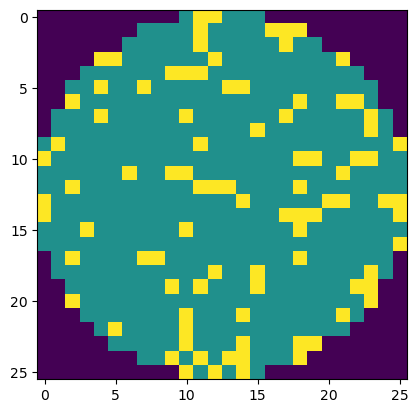

In [47]:
plt.imshow(np.argmax(new_x[3], axis=2))

449/449 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step


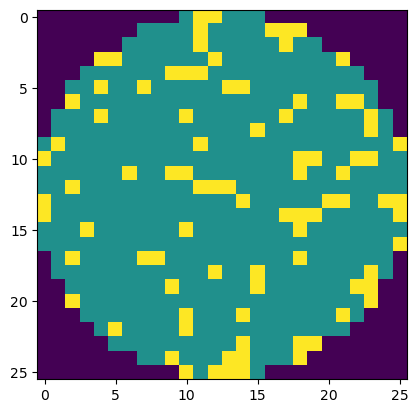

In [48]:
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [49]:
def gen_data(wafer, label):
    
    encoded_x = encoder.predict(wafer)
    gen_x = np.zeros((1, 26, 26, 3))
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    return gen_x[1:], gen_y[1:]

In [50]:
for f in faulty_case : 
    if f == 'none' : 
        continue   
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))
    
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

In [51]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [52]:
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)


In [53]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [54]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [55]:
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
new_y = to_categorical(new_y)
new_X=new_x[0:19000]
new_Y=new_y[0:19000]
test_x=new_x[19001:19706]
test_y=new_y[19001:19706]
test_x.shape

(705, 26, 26, 3)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(new_X, new_Y,test_size=0.33,random_state=2019)

In [57]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (12730, 26, 26, 3), y : (12730, 9)
Test x: (6270, 26, 26, 3), y : (6270, 9)
